In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [63]:
genome_scores = pd.read_csv('/content/genome_scores.csv').dropna()
ratings = pd.read_csv('/content/rating.csv').dropna()
tags = pd.read_csv('/content/tag.csv').dropna()
movies = pd.read_csv('/content/movie.csv').dropna()
genome_tags = pd.read_csv('/content/genome_tags.csv').dropna()
links = pd.read_csv('/content/link.csv').dropna()

In [64]:
print(genome_scores.columns)
print(ratings.columns)
print(tags.columns)
print(movies.columns)
print(genome_tags.columns)
print(links.columns)


Index(['movieId', 'tagId', 'relevance'], dtype='object')
Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')
Index(['movieId', 'title', 'genres'], dtype='object')
Index(['tagId', 'tag'], dtype='object')
Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')


In [65]:
data = pd.merge(movies,ratings)
data

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,1996-06-05 13:37:51
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0,1999-11-25 02:44:47
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5,2009-01-02 01:13:41
...,...,...,...,...,...,...
9272705,131164,Vietnam in HD (2011),War,54560,4.0,2015-03-29 22:16:09
9272706,131166,WWII IN HD (2009),(no genres listed),54560,4.0,2015-03-29 23:24:53
9272707,131168,Phoenix (2014),Drama,64060,3.5,2015-03-30 01:08:45
9272708,131231,Standby (2014),Comedy|Romance,63046,3.5,2015-03-30 14:04:06


In [66]:
user_ratings = data.groupby('userId')['movieId'].apply(list).to_dict()


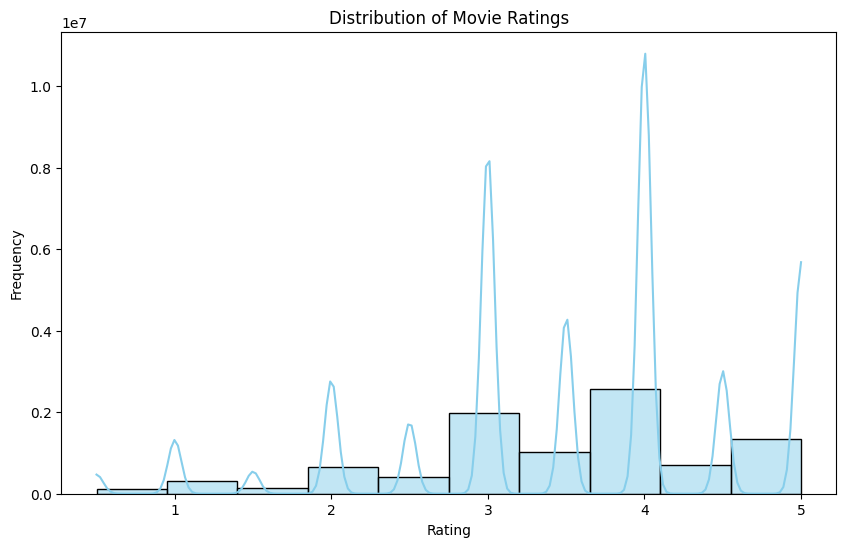

In [67]:
plt.figure(figsize=(10, 6))
sns.histplot(data['rating'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

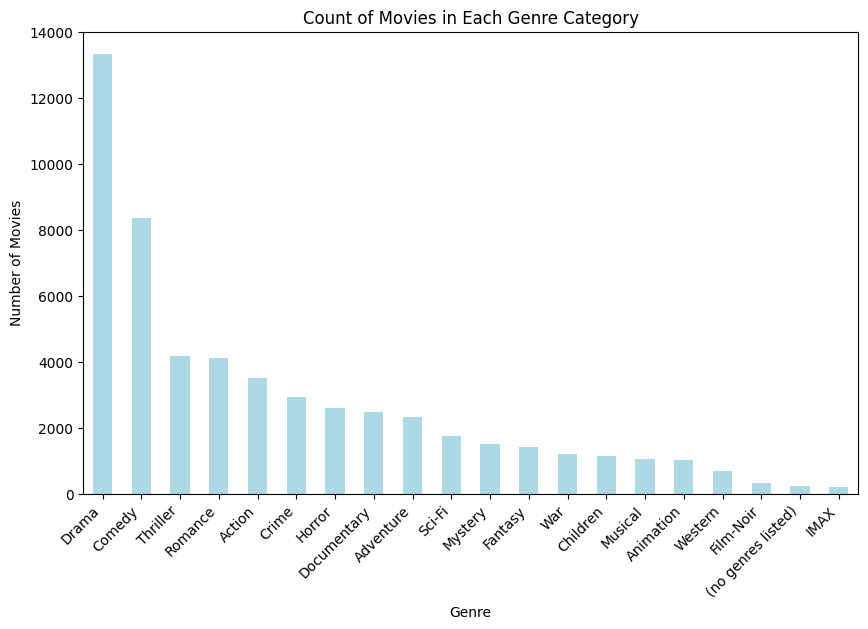

In [84]:
# Count of movies in each genre category
genre_counts = movies['genres'].str.split('|', expand=True).stack().value_counts()

# Bar chart of movie genres
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='lightblue')
plt.title('Count of Movies in Each Genre Category')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.show()



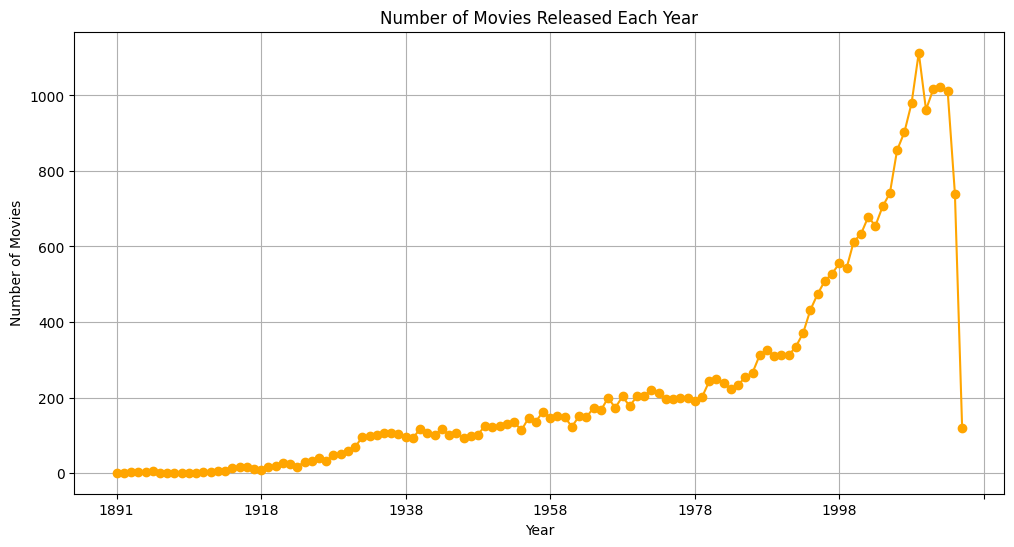

In [86]:
# Extract year from title and create a new column
movies['release_year'] = movies['title'].str.extract(r'\((\d{4})\)', expand=False)

# Count of movies released each year
year_counts = movies['release_year'].value_counts().sort_index()

# Line plot of movie release years
plt.figure(figsize=(12, 6))
year_counts.plot(kind='line', marker='o', color='orange')
plt.title('Number of Movies Released Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()



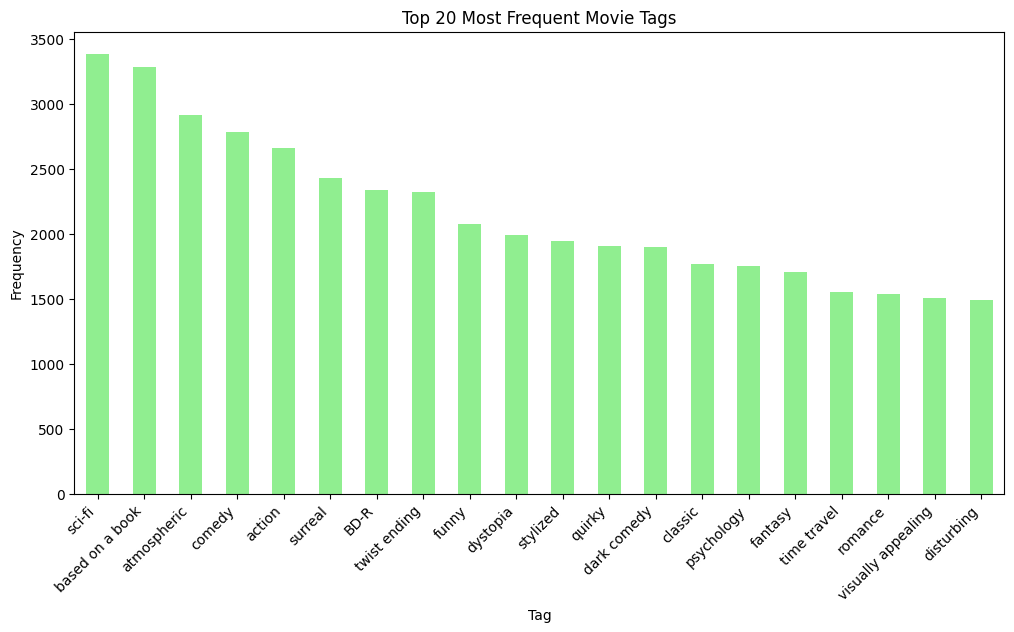

In [88]:
# Count of each tag
tag_counts = tags['tag'].value_counts().head(20)

# Bar chart of tag frequency
plt.figure(figsize=(12, 6))
tag_counts.plot(kind='bar', color='lightgreen')
plt.title('Top 20 Most Frequent Movie Tags')
plt.xlabel('Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()


Recommendation Generation based on genre

In [72]:
def recommend_movies(user_id, num_recommendations=5):
    rated_movies = user_ratings[user_id]
    unrated_movies = data[~data['movieId'].isin(rated_movies)]
    movie_scores = unrated_movies.groupby('movieId')['rating'].mean().reset_index()
    recommended_movies = movie_scores.sort_values(by='rating', ascending=False).head(num_recommendations)
    return recommended_movies

In [73]:
def recommend_movies_based_on_genres(user_preferences, num_recommendations=5):
    # Split user preferences into individual genres
    genres = user_preferences.split(',')
    recommended_movies = pd.DataFrame(columns=['movieId', 'rating'])
    # Filter movies based on each genre separately and concatenate the results
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre.strip(), case=False)]
        filtered_data = pd.merge(genre_movies, ratings)
        # Calculate average rating for each movie
        movie_scores = filtered_data.groupby('movieId')['rating'].mean().reset_index()
        recommended_movies = pd.concat([recommended_movies, movie_scores])
    # Calculate overall average rating for each movie
    recommended_movies = recommended_movies.groupby('movieId')['rating'].mean().reset_index()
    # Sort movies by average rating
    recommended_movies = recommended_movies.sort_values(by='rating', ascending=False).head(num_recommendations)
    # Merge with movie titles
    recommended_movies_with_titles = pd.merge(recommended_movies, movies, on='movieId', how='left')
    return recommended_movies_with_titles[['movieId', 'title', 'rating']]

In [74]:
def recommend_movies_based_on_tags(user_preferences, num_recommendations=5):
    # Split user preferences into individual values
    values = user_preferences.split(',')
    recommended_movies = pd.DataFrame(columns=['movieId', 'rating'])
    # Filter movies based on each tag separately and concatenate the results
    for value in values:
        # Find movie IDs with matching tags
        movie_ids = tags[tags['tag'].str.contains(value.strip(), case=False)]['movieId']
        # Filter movies based on matching movie IDs
        tag_movies = movies[movies['movieId'].isin(movie_ids)]
        # Merge with ratings data
        filtered_data = pd.merge(tag_movies, ratings)
        # Calculate average rating for each movie
        movie_scores = filtered_data.groupby('movieId')['rating'].mean().reset_index()
        recommended_movies = pd.concat([recommended_movies, movie_scores])
    # Calculate overall average rating for each movie
    recommended_movies = recommended_movies.groupby('movieId')['rating'].mean().reset_index()
    # Sort movies by average rating
    recommended_movies = recommended_movies.sort_values(by='rating', ascending=False).head(num_recommendations)
    # Merge with movie titles
    recommended_movies_with_titles = pd.merge(recommended_movies, movies, on='movieId', how='left')
    return recommended_movies_with_titles[['movieId', 'title', 'rating']]

In [75]:
def get_user_preferences():
    user_preferences = input("Enter your movie preferences (genres separated by commas): ")
    return user_preferences


The recommendation process involves filtering movies based on user preferences (genres or tags), calculating their average ratings, and recommending the top-rated movies in those categories.

In [83]:
attribute = input("Enter the attribute you want to base recommendations on (genres, tags): ")
user_preferences = get_user_preferences()

# Generate recommendations for the user based on preferences and attribute
if attribute == 'genres':
    recommendations = recommend_movies_based_on_genres(user_preferences)
elif attribute == 'tags':
    recommendations = recommend_movies_based_on_tags(user_preferences)

# Display recommendations
print("Recommended movies based on your preferences:")
print(recommendations)

Enter the attribute you want to base recommendations on (genres, tags): genres
Enter your movie preferences (genres separated by commas): Fantasy
Recommended movies based on your preferences:
   movieId                                    title  rating
0   130996               The Beautiful Story (1992)     5.0
1   119563             12 Dates of Christmas (2011)     5.0
2    32230  Snow Queen, The (Lumikuningatar) (1986)     5.0
3    73365                   Dead Time: Kala (2007)     5.0
4    79276                  Pont du Nord, Le (1981)     5.0


In [89]:
attribute = input("Enter the attribute you want to base recommendations on (genres, tags): ")
user_preferences = get_user_preferences()

# Generate recommendations for the user based on preferences and attribute
if attribute == 'genres':
    recommendations = recommend_movies_based_on_genres(user_preferences)
elif attribute == 'tags':
    recommendations = recommend_movies_based_on_tags(user_preferences)

# Display recommendations
print("Recommended movies based on your preferences:")
print(recommendations)

Enter the attribute you want to base recommendations on (genres, tags): tags
Enter your movie preferences (genres separated by commas): Sci-Fi
Recommended movies based on your preferences:
   movieId                                              title    rating
0    93473                   Pale Cocoon (Peiru Kokun) (2006)  4.375000
1   128991                              Johnny Express (2014)  4.333333
2      260          Star Wars: Episode IV - A New Hope (1977)  4.196458
3     2571                                 Matrix, The (1999)  4.186231
4     1196  Star Wars: Episode V - The Empire Strikes Back...  4.178901
